In [ ]:
"""
A combustor, modeled as a single well-stirred reactor.

We are interested in the steady-state burning solution. This example explores
the effect of changing the residence time on completeness of reaction (through
the burned gas temperature) and on the total heat release rate.

Demonstrates the use of a MassFlowController where the mass flow rate function
depends on variables other than time by capturing these variables from the
enclosing scope. Also shows the use of a PressureController to create a constant
pressure reactor with a fixed volume.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct

In [2]:
# Use reaction mechanism GRI-Mech 3.0
gas = ct.Solution('gri30.xml')

In [3]:
# Create a Reservoir for the inlet, set to a methane/air mixture at a specified
# equivalence ratio
equiv_ratio = 0.5  # lean combustion
gas.TP = 300.0, ct.one_atm
gas.set_equivalence_ratio(equiv_ratio, 'CH4:1.0', 'O2:1.0, N2:3.76')
inlet = ct.Reservoir(gas)

In [4]:
# Create the combustor, and fill it initially with a mixture consisting of the
# equilibrium products of the inlet mixture. This state corresponds to the state
# the reactor would reach with infinite residence time, and thus provides a good
# initial condition from which to reach a steady-state solution on the reacting
# branch.
gas.equilibrate('HP')
combustor = ct.IdealGasReactor(gas)
combustor.volume = 1.0

In [5]:
# Create a reservoir for the exhaust
exhaust = ct.Reservoir(gas)

In [6]:
# Use a variable mass flow rate to keep the residence time in the reactor
# constant (residence_time = mass / mass_flow_rate). The mass flow rate function
# can access variables defined in the calling scope, including state variables
# of the Reactor object (combustor) itself.

def mdot(t):
    return combustor.mass / residence_time

inlet_mfc = ct.MassFlowController(inlet, combustor, mdot=mdot)

In [7]:
# A PressureController has a baseline mass flow rate matching the 'master'
# MassFlowController, with an additional pressure-dependent term. By explicitly
# including the upstream mass flow rate, the pressure is kept constant without
# needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(combustor, exhaust, master=inlet_mfc, K=0.01)

# the simulation only contains one reactor
sim = ct.ReactorNet([combustor])

In [8]:
# Run a loop over decreasing residence times, until the reactor is extinguished,
# saving the state after each iteration.
states = ct.SolutionArray(gas, extra=['tres'])

residence_time = 0.1  # starting residence time
while combustor.T > 500:
    sim.set_initial_time(0.0)  # reset the integrator
    sim.advance_to_steady_state()
    print('tres = {:.2e}; T = {:.1f}'.format(residence_time, combustor.T))
    states.append(combustor.thermo.state, tres=residence_time)
    residence_time *= 0.9  # decrease the residence time for the next iteration

tres = 1.00e-01; T = 1475.8
tres = 9.00e-02; T = 1475.4
tres = 8.10e-02; T = 1474.9
tres = 7.29e-02; T = 1474.5
tres = 6.56e-02; T = 1474.0
tres = 5.90e-02; T = 1473.4
tres = 5.31e-02; T = 1472.9
tres = 4.78e-02; T = 1472.2
tres = 4.30e-02; T = 1471.6
tres = 3.87e-02; T = 1470.9
tres = 3.49e-02; T = 1470.1
tres = 3.14e-02; T = 1469.3
tres = 2.82e-02; T = 1468.4
tres = 2.54e-02; T = 1467.5
tres = 2.29e-02; T = 1466.5
tres = 2.06e-02; T = 1465.4
tres = 1.85e-02; T = 1464.2
tres = 1.67e-02; T = 1463.0
tres = 1.50e-02; T = 1461.6
tres = 1.35e-02; T = 1460.2
tres = 1.22e-02; T = 1458.6
tres = 1.09e-02; T = 1456.9
tres = 9.85e-03; T = 1455.1
tres = 8.86e-03; T = 1453.1
tres = 7.98e-03; T = 1451.0
tres = 7.18e-03; T = 1448.7
tres = 6.46e-03; T = 1446.2
tres = 5.81e-03; T = 1443.4
tres = 5.23e-03; T = 1440.5
tres = 4.71e-03; T = 1437.2
tres = 4.24e-03; T = 1433.7
tres = 3.82e-03; T = 1429.8
tres = 3.43e-03; T = 1425.5
tres = 3.09e-03; T = 1420.7
tres = 2.78e-03; T = 1415.3
tres = 2.50e-03; T =

In [10]:
# Heat release rate [W/m^3]
Q = - np.sum(states.net_production_rates * states.partial_molar_enthalpies, axis=1)
Q

array([3.29759569e+06, 3.66350590e+06, 4.06998025e+06, 4.52150815e+06,
       5.02307438e+06, 5.58021349e+06, 6.19907006e+06, 6.88646550e+06,
       7.64997208e+06, 8.49799498e+06, 9.43986307e+06, 1.04859296e+07,
       1.16476834e+07, 1.29378722e+07, 1.43706389e+07, 1.59616718e+07,
       1.77283718e+07, 1.96900350e+07, 2.18680563e+07, 2.42861521e+07,
       2.69706065e+07, 2.99505410e+07, 3.32582118e+07, 3.69293335e+07,
       4.10034344e+07, 4.55242413e+07, 5.05400969e+07, 5.61044073e+07,
       6.22761183e+07, 6.91202119e+07, 7.67082108e+07, 8.51186646e+07,
       9.44375672e+07, 1.04758605e+08, 1.16183027e+08, 1.28818647e+08,
       1.42776671e+08, 1.58162087e+08, 1.75037208e+08, 1.93074108e+08,
       1.07040405e-17])

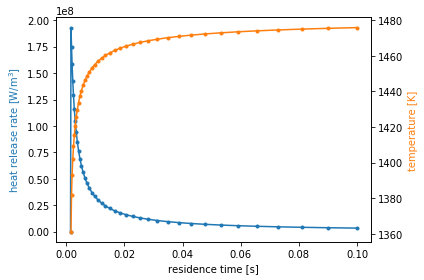

In [11]:
# Plot results
f, ax1 = plt.subplots(1,1)
ax1.plot(states.tres, Q, '.-', color='C0')
ax2 = ax1.twinx()
ax2.plot(states.tres[:-1], states.T[:-1], '.-', color='C1')
ax1.set_xlabel('residence time [s]')
ax1.set_ylabel('heat release rate [W/m$^3$]', color='C0')
ax2.set_ylabel('temperature [K]', color='C1')
f.tight_layout()
plt.show()

In [12]:
# https://cantera.org/examples/python/reactors/combustor.py.html